# Steam Reviews Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

## Business Understanding
The objective of the notebook is to be able to predict whether or not a game will be recommended based off the review. By analyzing reviews, the model identifies key words and phrases that lead to positive or negative recommendations. This can help game developers and marketers understand what aspects of a game are most appreciated by users when creating a sequel or a game in a specific genre.

## Data Understanding

The data we will be looking at is a dataset acquired from Kaggle containing Steam reviews from 2017 and before.
> https://www.kaggle.com/datasets/andrewmvd/steam-reviews



Loading the data

In [3]:
df = pd.read_csv('../data/dataset.csv')

Sneak peek of the data

In [4]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


## Data Cleaning

Dropping duplicates and NA

In [6]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4483850 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 205.3+ MB


In [7]:
df.reset_index(drop=True, inplace=True)

In [8]:
df

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1
...,...,...,...,...,...
4483845,99910,Puzzle Pirates,I really ove this game but it needs somethings...,-1,0
4483846,99910,Puzzle Pirates,"Used to play Puzzel Pirates 'way back when', b...",-1,0
4483847,99910,Puzzle Pirates,"This game was aright, though a bit annoying. W...",-1,0
4483848,99910,Puzzle Pirates,"I had a nice review to recommend this game, bu...",-1,0


In [9]:
data = df[['review_text', 'review_score']]

In [10]:
data_sample = data.sample(frac=0.05, random_state=42)
data_sample

,review_text,review_score
2431934,old school!,1
1250528,Game is very fun. It could use some tweeking a...,1
590126,A short emotionally provocative game that tran...,1
2110494,"Freedom fall is a short, simple, and very fun ...",1
2527583,I have played the witcher 2 and i can say that...,1
...,...,...
3350267,Larian managed to make the best RPG of the 201...,1
833185,You couldn’t pick up a guy at the gay bar Male...,1
3873486,"What is this game even? Honestly, no one knows...",1
4126649,"Seriously, buy this game. With all of the mod ...",1


In [45]:
data_sample.value_counts(['review_score'])

review_score
 1              183903
-1               40289
Name: count, dtype: int64

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_sample['review_text'], data_sample['review_score'], test_size=0.2, random_state=42)

In [12]:
# remove stop words
stop_words = list(text.ENGLISH_STOP_WORDS)

In [46]:
tfidf = TfidfVectorizer(max_features=5000, stop_words=stop_words, ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Training the Model

### Dummy Model

In [18]:
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train_tfidf, y_train)
y_pred_baseline = baseline_model.predict(X_test_tfidf)
y_pred_baseline

array([1, 1, 1, ..., 1, 1, 1])

### First Model

In [14]:
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, verbose=3)
grid_search.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.819 total time= 1.2min
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.817 total time= 5.7min
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.820 total time= 1.2min
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.819 total time= 1.1min
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.818 total time= 1.2min
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10;, score=0.816 total time= 1.1min
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10;, score=0.815 total time= 7.4min
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10;, score=0.817 total time= 1.1min
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=10;, score=0.814 total time= 1.1min
[CV 5/5] END max_

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 10]},
             verbose=3)

grabbing the model from the gridSearch

In [19]:
best_model = grid_search.best_estimator_

evlauating the first tuned model

In [20]:
y_pred_tuned = best_model.predict(X_test_tfidf)
print("Tuned Decision Tree Model Performance:")
print(classification_report(y_test, y_pred_tuned))

Tuned Decision Tree Model Performance:
              precision    recall  f1-score   support

          -1       0.67      0.26      0.38      7977
           1       0.86      0.97      0.91     36862

    accuracy                           0.85     44839
   macro avg       0.76      0.62      0.65     44839
weighted avg       0.83      0.85      0.82     44839



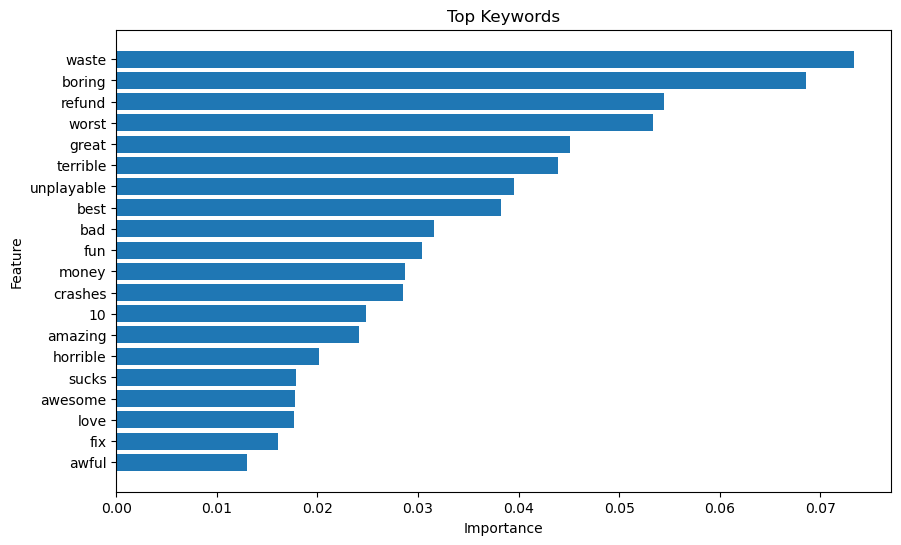

In [21]:
# Feature importance
feature_names = tfidf.get_feature_names_out()
importance = best_model.feature_importances_
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot top keywords
top_features = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:top_features], feature_importance['importance'][:top_features])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Keywords')
plt.gca().invert_yaxis()
plt.show()

In [47]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model Performance:
              precision    recall  f1-score   support

          -1       0.77      0.41      0.54      7977
           1       0.88      0.97      0.93     36862

    accuracy                           0.87     44839
   macro avg       0.83      0.69      0.73     44839
weighted avg       0.86      0.87      0.86     44839



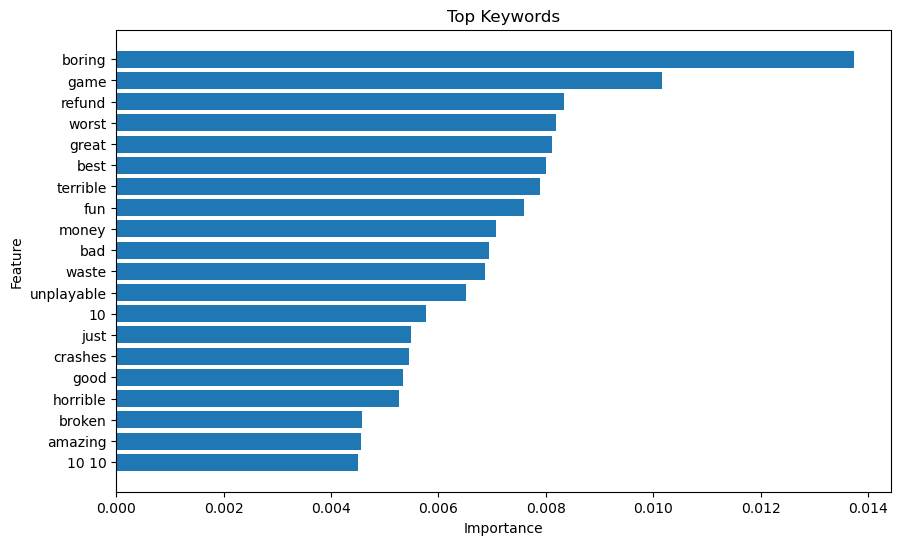

In [48]:
# Feature importance
feature_names = tfidf.get_feature_names_out()
importance = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot top keywords
top_features = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:top_features], feature_importance['importance'][:top_features])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Keywords')
plt.gca().invert_yaxis()
plt.show()

In [53]:
# Example new review
new_review = ["waste i hated it"]

# Transform the new review
new_review_tfidf = tfidf.transform(new_review)

# Make prediction using the best model (assuming best_model is already defined and trained)
prediction = rf_model.predict(new_review_tfidf)
print(prediction)

# Interpret the prediction
if prediction[0] == 1:
    print("The model predicts: Recommended")
else:
    print("The model predicts: Not Recommended")

[-1]
The model predicts: Not Recommended
